<a href="https://colab.research.google.com/github/soneyahossain/deep_learning_project/blob/master/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip DATA-2.zip


In [2]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        #print(image_ids[0])
        #print(label_ids[0])
        #print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_, image_name,class_name 
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

trainset = UVaBuildinglabel('DATA', 'trainSet-2.csv')
valset = UVaBuildinglabel('DATA', 'valSet-2.csv')

trainset1 = DataLoader(trainset, shuffle=True)
valset1=DataLoader(valset, shuffle=True)
print("total training data",trainset.__len__())
print("total validation data",valset.__len__())

Loading data...
Loading data...
total training data 616
total validation data 153


In [0]:
import matplotlib.pyplot as plt

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']


for (i, (my_image, my_label,_,class_name)) in enumerate(trainset1):    

  #print(my_image.shape)
  print(my_label)
  print(classes[my_label])

# Show the image and its label.
plt.figure()
plt.title("This picture has: "+ classes[my_label])
# Undo normalization of the pixel values.

# Re-arrange dimensions so it is height x width x channels.
plt.imshow(my_image[0].transpose(0,2).transpose(0,1));
#plt.grid(False); plt.axis('off');

This dataset has 616 training images
9
320
Image 320 is a Newcomb Hall
Image size is 3x320x320


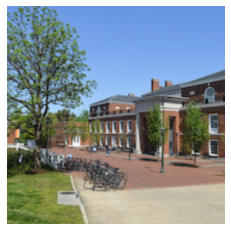

In [4]:
import torchvision.transforms.functional as F

image_index = 320  # Feel free to change this.

# 1. Datasets need to implement the __len__ method for this to work.
print('This dataset has {0} training images'.format(len(trainset1.dataset)))

# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label,_,class_name = trainset1.dataset.__getitem__(image_index)  # Returns image and label.

print(label)
print(image_index)
print('Image {0} is a {1}'.format(image_index, class_name))
print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))
# All images have 1 channel x 28 rows x 28 columns.

plt.figure()
plt.imshow(img.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off')
plt.show()

In [0]:
# Softmax function: exp(a) / sum(exp(a))
# Note that this function works for tensors of any shape, it is not a scalar function.
def softmax(a):
    max_val = a.max()  # This is to avoid variable overflows.
    exp_a = (a - max_val).exp()
    return exp_a.div(exp_a.sum())

# Classification function: y = softmax(Wx + b)
# Again, note this function is operating on vectors.
def linear(x, weight, bias):
    return torch.matmul(weight, x) + bias


def loss(label, predictions):
    return -predictions[label].log()

# This computes dL / da = y_hat - y.
def loss_softmax_backward(label, predictions):
    grad_inputs = predictions.clone()
    grad_inputs[label] = grad_inputs[label].item() - 1
    return grad_inputs


def linear_backward(x, weight, bias, gradOutput):
    gradBias = bias.clone().zero_()
    gradWeight = weight.clone().zero_()
    
    gradWeight = gradOutput * x.t()   # dL / dW[i,j] = x[j] * dL / da 
    gradBias.copy_(gradOutput)   # dL / dB[i] = 1 * dL / da
    return gradWeight, gradBias

In [0]:
import torch, torchvision, matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Your code.

# Define a learning rate. 
learningRate = 1e-4

# Define number of epochs.
N = 20

# Initialize bias and weight with random values again.
weight = torch.empty(20, 3 * 320 * 320).normal_(0, 0.01)
bias = torch.zeros(20, 1)

# log accuracies and losses.
train_accuracies = []; 
val_accuracies = []
train_losses = []; 
val_losses = []

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, N):
    correct = 0.0
    cum_loss = 0.0

    #for i in range(0, 100):
        #img, label,_,class_name = trainset.__getitem__(i)
    
    #Make a pass over the training data.
    for (i, (img, label,_,class_name)) in enumerate(trainset1):  
        x = img[0]
        x = x.view(3 * 320 * 320, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        #print(predictions)
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)

        #print("max_score: ",max_score)
        #print("max_label:", max_label)
        #print("actual_label", label)

        if max_label[0] == label: correct += 1
        
        #Backward pass. (Gradient computation stage)
        gradOutput = loss_softmax_backward(label, predictions)
        gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)
        
        # Parameter updates.
        weight.add_(-learningRate, gradWeight)
        bias.add_(-learningRate, gradBias)
        
        # Logging the current results on training.
        if (i + 1) % 100 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i + 1)))
    
    train_accuracies.append(correct / len(trainset1))
    train_losses.append(cum_loss / len(trainset1))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    #for j in range(0, 100):
        #img, label,_,class_name = valset.__getitem__(j)
    for (i, (img, label,_,class_name)) in enumerate(valset1):  
        x = img[0]
        x = x.view(3 * 320 * 320, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions).item()
        max_score, max_label = predictions.max(0)
        
        #print("val_max_score: ",max_score)
        #print("val_max_label:", max_label)
        #print("val_actual_label", label)

        if max_label[0] == label: correct += 1
          
          
    val_accuracies.append(correct / len(valset1))
    val_losses.append(cum_loss / len(valset1))
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / len(valset1), correct / len(valset1)))
#--------------------------------------------------------------------------

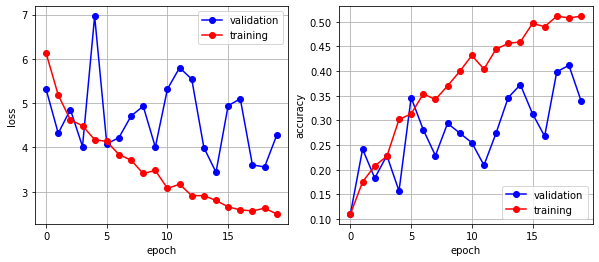

In [8]:

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.grid('on')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

ground truth: Rice Hall
Image 117 is a Slaughter Recreation


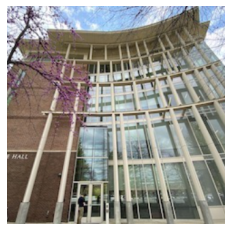

In [30]:
#do some predictions

image_index = 117  # Feel free to change this.
# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label,_,class_name = valset1.dataset.__getitem__(image_index)  # Returns image and label.
x = x.view(3 * 320 * 320, 1)

# Forward pass. (Prediction stage)
predictions = softmax(linear(x, weight, bias))
#print(predictions)
max_score, max_label = predictions.max(0)

print("ground truth:", classes[label])
print('Image {0} is a {1}'.format(image_index, classes[max_label]))
#print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))
#All images have 1 channel x 28 rows x 28 columns.

plt.figure()
plt.imshow(img.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off')
plt.show()

In [31]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

for (i, (img, label,_,class_name)) in enumerate(valset1):  
    
    x = img[0]
    x = x.view(3 * 320 * 320, 1)
    #inputs = inputs.to(device)
    #classes = classes.to(device)
    #outputs = model_ft(inputs)

    ground_truth_label = label
    outputs = softmax(linear(x, weight, bias))
    max_score, prediction = outputs.max(0)

    #print("GT: ", classes[ground_truth_label])
    #print("pred: ",classes[prediction])
    
    confusion_matrix[label.long(),prediction.long()] += 1

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))


for i in range(0, 20):

  print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall','Newcomb Hall', 'North Grounds Gym',
           'Old Cabell Hall', 'Olsson Hall','Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

accuracy for  Alderman Library is :  0.0
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.0
accuracy for  Chemical Engineering Building is :  0.0
accuracy for  John Paul Jones Arena is :  0.800000011920929
accuracy for  Law School Building is :  0.7692307829856873
accuracy for  Mechanical Building is :  0.6428571343421936
accuracy for  Memorial Gym is :  0.0
accuracy for  Monroe Hall is :  0.25
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.0
accuracy for  Old Cabell Hall is :  0.0
accuracy for  Olsson Hall is :  0.4545454680919647
accuracy for  Physics Building is :  0.07692307978868484
accuracy for  Rice Hall is :  0.3333333432674408
accuracy for  The Rotunda is :  0.20000000298023224
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  0.0
accuracy for  Wilsdorf Hall is :  0.1666666716337204
